In [11]:
import json
import numpy as np
from google.colab import drive
drive.mount("/content/drive")

def report_statistics(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()
        max_time = 0
        min_time = np.inf
        total_followers = 0
        total_retweets = 0
        total_tweets = len(lines)
        for line in lines:
            json_obj = json.loads(line)
            if json_obj['citation_date'] > max_time:
                max_time = json_obj['citation_date']
            if json_obj['citation_date'] < min_time:
                min_time = json_obj['citation_date']
            total_followers += json_obj['author']['followers']
            total_retweets += json_obj['metrics']['citations']['total']
        avg_tweets_per_h = total_tweets * 3600 / (max_time - min_time)
        avg_followers_per_tweet = total_followers / total_tweets
        avg_retweets_per_tweet = total_retweets / total_tweets
        print(filename)
        print('Average number of tweets per hour: ', avg_tweets_per_h)
        print('Average number of followers of users posting the tweets per tweet: ', avg_followers_per_tweet)
        print('Average number of retweets per tweet: ', avg_retweets_per_tweet)
        print('-' * 50)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
import datetime
import time
import pytz

pst_tz = pytz.timezone('America/Los_Angeles')

pre_active_time = datetime.datetime(2015, 2, 1, 8, 0, 0, 0, pst_tz)
post_active_time = datetime.datetime(2015, 2, 1, 20, 0, 0, 0, pst_tz)
pre_active_timestamp = time.mktime(pre_active_time.timetuple())
post_active_timestamp = time.mktime(post_active_time.timetuple())

##Fan Base Prediction

In [ ]:
import json

# exclude any tweets whose author is not from Washington or Massachusetts
WA_substrings = ['Washington', 'Seattle', 'WA']
MA_substrings = ['Massachusetts', 'Boston', 'MA']

superbowl_dataset_trimmed = []

with open('ECE219_tweet_data/tweets_#superbowl.txt', 'r') as file:
    lines = file.readlines()
    
    for line in lines:
        json_obj = json.loads(line)
        location = json_obj['tweet']['user']['location']
        
        for w in WA_substrings:
            if w in location:
                superbowl_dataset_trimmed.append((json_obj['tweet']['text'], 'Washington'))
                break
                
        for m in MA_substrings:
            if m in location:
                superbowl_dataset_trimmed.append((json_obj['tweet']['text'], 'Massachusetts'))
                break

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

x_superbowl = np.array(superbowl_dataset_trimmed)[:, 0]
y_superbowl = np.array(superbowl_dataset_trimmed)[:, 1]

y_superbowl_binary = np.zeros(y_superbowl.shape)
y_superbowl_binary[y_superbowl == 'Washington'] = 1

x_train, x_test, y_train, y_test = train_test_split(x_superbowl, y_superbowl_binary, test_size=0.1, random_state=42)

In [13]:
import nltk
# nltk.download('wordnet')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')

from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from collections import defaultdict

# pos_tags: treebank to wordnet
tag_map = defaultdict(lambda: wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

wnl = WordNetLemmatizer()
    
def lemmatize(data):
    lemmatized = []
    for doc in data:
        tokens = word_tokenize(doc)
        words = [wnl.lemmatize(word, tag_map[tag[0]]) for word,tag in pos_tag(tokens) 
                 if wnl.lemmatize(word, tag_map[tag[0]]).isalpha()]
        sentence = ' '.join(words)
        lemmatized.append(sentence)
    return lemmatized

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

x_train_lemmatized = lemmatize(x_train)
x_test_lemmatized = lemmatize(x_test)

tfidf_vectorizer = TfidfVectorizer(stop_words='english', min_df=3)
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train_lemmatized)
x_test_tfidf = tfidf_vectorizer.transform(x_test_lemmatized)

svd = TruncatedSVD(n_components=50, random_state=42)
x_train_svd = svd.fit_transform(x_train_tfidf)
x_test_svd = svd.transform(x_test_tfidf)

In [ ]:
# Logistic Regression: GridSearch
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import pandas as pd


grid_logistic = GridSearchCV(estimator=LogisticRegression(random_state=42), 
                        param_grid={'C':[10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3],
                                   'penalty': ['l1', 'l2', 'elasticnet']}, 
                        cv=5, n_jobs=-1, verbose=1).fit(x_train_svd, y_train)

result_logistic = pd.DataFrame(grid_logistic.cv_results_)[['mean_test_score', 'param_C', 'param_penalty']]
result_logistic = result_logistic.sort_values(by=['mean_test_score'], ascending=False).reset_index(drop=True)
result_logistic.head()

Fitting 5 folds for each of 21 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:    2.1s finished


,mean_test_score,param_C,param_penalty
0,0.724697,100,l2
1,0.724651,10,l2
2,0.724651,1000,l2
3,0.723890,1,l2
4,0.719582,0.1,l2


In [ ]:
logistic_optim = LogisticRegression(penalty=grid_logistic.best_params_['penalty'], 
                                    C=grid_logistic.best_params_['C'], random_state=42)

logistic_optim.fit(x_train_svd, y_train)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

y_pred_logistic = logistic_optim.predict(x_test_svd)
y_pred_prob_logistic = logistic_optim.predict_proba(x_test_svd)[:,1]

print('Logistic Regression:')
print('confusion_matrix:\n', confusion_matrix(y_test, y_pred_logistic))
print('accuracy:', accuracy_score(y_test, y_pred_logistic))
print('recall:', recall_score(y_test, y_pred_logistic))
print('precision:', precision_score(y_test, y_pred_logistic))
print('f1_score:', f1_score(y_test, y_pred_logistic))

Logistic Regression:
confusion_matrix:
 [[1042 1117]
 [ 204 2460]]
accuracy: 0.7261040845946506
recall: 0.9234234234234234
precision: 0.6877271456527817
f1_score: 0.7883352026918764


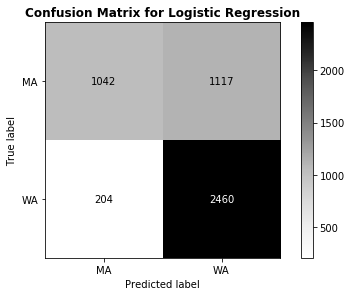

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

class_names = ['MA', 'WA']

plot_confusion_matrix(logistic_optim, x_test_svd, y_test, display_labels=class_names, 
                             values_format='d', cmap=plt.cm.Greys)
plt.tight_layout()
plt.title('Confusion Matrix for Logistic Regression', fontweight='bold')
plt.show()

In [ ]:
# RandomForest: GridSearch
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

pipe_rfc = Pipeline([
    ('standardize', StandardScaler()),
    ('model', RandomForestClassifier(random_state=42))
])

param_grid = {
    'model__max_depth': [10, 30, 50, 70, 100, 200, None]
}


grid_rfc = GridSearchCV(pipe_rfc, param_grid=param_grid, cv=KFold(5, shuffle=True, random_state=42), n_jobs=-1, verbose=1)
grid_rfc.fit(x_train_svd, y_train)

result_rfc = pd.DataFrame(grid_rfc.cv_results_)[['mean_test_score', 'param_model__max_depth']]
result_rfc = result_rfc.sort_values(by=['mean_test_score'], ascending=False).reset_index(drop=True)
result_rfc.head()

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  35 | elapsed:   38.6s remaining:   17.7s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  1.1min finished


,mean_test_score,param_model__max_depth
0,0.724766,30
1,0.722623,70
2,0.722623,100
3,0.722623,200
4,0.722623,None


In [ ]:
pipe_rfc_optim = Pipeline([
        ('standardize', StandardScaler()),
        ('model', RandomForestClassifier(max_depth=30, random_state=42))
])

pipe_rfc_optim.fit(x_train_svd, y_train)

Pipeline(memory=None,
         steps=[('standardize',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=30, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=42,
                                        verbose=0, warm_start=False))],
         verbose=False)

In [ ]:
y_pred_rfc = pipe_rfc_optim.predict(x_test_svd)
y_pred_prob_rfc = pipe_rfc_optim.predict_proba(x_test_svd)[:,1]

print('Logistic Regression:')
print('confusion_matrix:\n', confusion_matrix(y_test, y_pred_rfc))
print('accuracy:', accuracy_score(y_test, y_pred_rfc))
print('recall:', recall_score(y_test, y_pred_rfc))
print('precision:', precision_score(y_test, y_pred_rfc))
print('f1_score:', f1_score(y_test, y_pred_rfc))

Logistic Regression:
confusion_matrix:
 [[1320  839]
 [ 474 2190]]
accuracy: 0.7277628032345014
recall: 0.8220720720720721
precision: 0.7230108946847145
f1_score: 0.7693658879325488


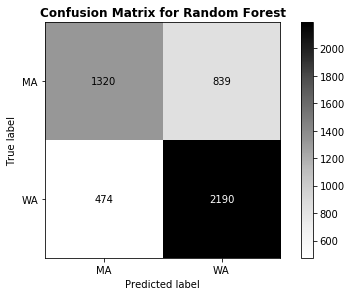

In [ ]:
plot_confusion_matrix(pipe_rfc_optim, x_test_svd, y_test, display_labels=class_names, 
                             values_format='d', cmap=plt.cm.Greys)
plt.tight_layout()
plt.title('Confusion Matrix for Random Forest', fontweight='bold')
plt.show()

In [ ]:
# GradientBoosting: GridSearch
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier

pipe_gbc = Pipeline([
    ('standardize', StandardScaler()),
    ('model', GradientBoostingClassifier(random_state=42))
])

param_grid = {
    'model__max_depth': [10, 30, 50, 70, 100, 200, None]
}


grid_gbc = GridSearchCV(pipe_gbc, param_grid=param_grid, cv=KFold(5, shuffle=True, random_state=42), n_jobs=-1, verbose=1)
grid_gbc.fit(x_train_svd, y_train)

result_gbc = pd.DataFrame(grid_gbc.cv_results_)[['mean_test_score', 'param_model__max_depth']]
result_gbc = result_gbc.sort_values(by=['mean_test_score'], ascending=False).reset_index(drop=True)
result_gbc.head()

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  35 | elapsed:  8.1min remaining:  3.7min
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed: 14.0min finished


,mean_test_score,param_model__max_depth
0,0.721978,10
1,0.698132,30
2,0.687141,70
3,0.686980,100
4,0.686980,200


In [ ]:
pipe_gbc_optim = Pipeline([
        ('standardize', StandardScaler()),
        ('model', GradientBoostingClassifier(max_depth=10, random_state=42))
])

pipe_gbc_optim.fit(x_train_svd, y_train)

Pipeline(memory=None,
         steps=[('standardize',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 GradientBoostingClassifier(ccp_alpha=0.0,
                                            criterion='friedman_mse', init=None,
                                            learning_rate=0.1, loss='deviance',
                                            max_depth=10, max_features=None,
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=100,
                                            n_iter_no_change=None,
          

In [ ]:
y_pred_gbc = pipe_gbc_optim.predict(x_test_svd)
y_pred_prob_gbc = pipe_gbc_optim.predict_proba(x_test_svd)[:,1]

print('Logistic Regression:')
print('confusion_matrix:\n', confusion_matrix(y_test, y_pred_gbc))
print('accuracy:', accuracy_score(y_test, y_pred_gbc))
print('recall:', recall_score(y_test, y_pred_gbc))
print('precision:', precision_score(y_test, y_pred_gbc))
print('f1_score:', f1_score(y_test, y_pred_gbc))

Logistic Regression:
confusion_matrix:
 [[1341  818]
 [ 496 2168]]
accuracy: 0.72755546340452
recall: 0.8138138138138138
precision: 0.7260549229738781
f1_score: 0.767433628318584


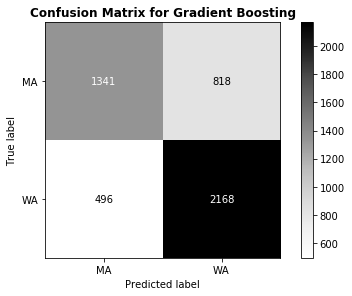

In [ ]:
plot_confusion_matrix(pipe_gbc_optim, x_test_svd, y_test, display_labels=class_names, 
                             values_format='d', cmap=plt.cm.Greys)
plt.tight_layout()
plt.title('Confusion Matrix for Gradient Boosting', fontweight='bold')
plt.show()

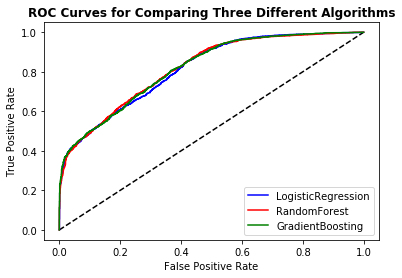

In [ ]:
# aggregated ROC curves
from sklearn.metrics import roc_curve

fpr_logistic, tpr_logistic, _ = roc_curve(y_test, y_pred_prob_logistic)
fpr_rfc, tpr_rfc, _ = roc_curve(y_test, y_pred_prob_rfc)
fpr_gbc, tpr_gbc, _ = roc_curve(y_test, y_pred_prob_gbc)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_logistic, tpr_logistic, label = 'LogisticRegression', color='b', linewidth=1.5)
plt.plot(fpr_rfc, tpr_rfc, label = 'RandomForest', color='r', linewidth=1.5)
plt.plot(fpr_gbc, tpr_gbc, label = 'GradientBoosting', color='g', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('ROC Curves for Comparing Three Different Algorithms', weight='bold')
plt.show()

In [14]:
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from collections import defaultdict

# pos_tags: treebank to wordnet
tag_map = defaultdict(lambda: wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

wnl = WordNetLemmatizer()
    
def lemmatize_tweet(tweet):
    tokens = word_tokenize(tweet)
    words = [wnl.lemmatize(word, tag_map[tag[0]]) for word,tag in pos_tag(tokens) 
             if wnl.lemmatize(word, tag_map[tag[0]]).isalpha()]
    sentence = ' '.join(words)
    return sentence

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [15]:
import math
import json
import numpy as np
from textblob import TextBlob
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
def perform_sentiment_analysis(filename, min_time=pre_active_timestamp, max_time=post_active_timestamp):
    with open(filename, 'r') as file:
        lines = file.readlines()
        
        num_time_window = math.ceil((max_time - min_time) / (3600))
        
        # initialization
        sentiment_summary = []
        y=[]
        tweets = []
        for _ in range(num_time_window):
            sentiment_summary.append([])
        positive_tweets, negative_tweets = np.zeros((num_time_window, 1)), np.zeros((num_time_window, 1))
            
        for line in lines:
            # retrieve index of one-hour time window
            json_obj = json.loads(line)
            date = json_obj['citation_date']
            if min_time <= date <= max_time:
                index = math.floor((date - min_time) / 3600)
                # sentiment polarity
                tweet = json_obj['tweet']['text']
                polarity = TextBlob(lemmatize_tweet(tweet)).sentiment.polarity
                if polarity > 0:
                    #positive_tweets[index, 0] += 1
                    tweets.append(tweet)
                    y.append(1) 
                elif polarity < 0:
                    #negative_tweets[index, 0] += 1
                    tweets.append(tweet)
                    y.append(0)

                sentiment_summary[index].append(polarity)
        
        sentiment_dist = []
        for x in sentiment_summary:
            if x:
                sentiment_dist.append(np.mean(x))
            else:
                sentiment_dist.append(sentiment_dist[-1])
        return sentiment_dist, tweets, y, positive_tweets, negative_tweets

In [16]:
seahawks_sentiment,tweets_hawks, y_hawks, seahawks_positive, seahawks_negative = perform_sentiment_analysis('/content/drive/MyDrive/ECE219/Project4/ECE219_tweet_data/tweets_#gohawks.txt')
patriots_sentiment, tweets_patriots, y_patriots, patriots_positive, patriots_negative = perform_sentiment_analysis('/content/drive/MyDrive/ECE219/Project4/ECE219_tweet_data/tweets_#gopatriots.txt')

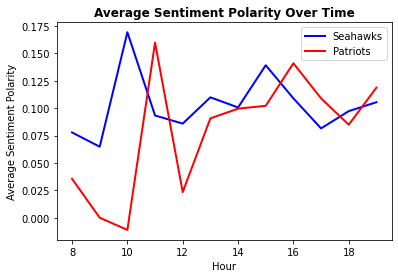

In [17]:
plt.plot(np.arange(8, 20), seahawks_sentiment, label='Seahawks', color='b', linewidth=2)
plt.plot(np.arange(8, 20), patriots_sentiment, label='Patriots', color='r', linewidth=2)
plt.xlabel('Hour')
plt.ylabel('Average Sentiment Polarity')
plt.legend()
plt.title('Average Sentiment Polarity Over Time', weight='bold')
plt.show()

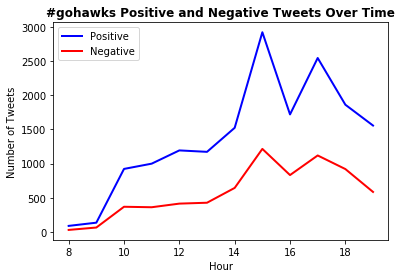

In [ ]:
plt.plot(np.arange(8, 20), seahawks_positive, label='Positive', color='b', linewidth=2)
plt.plot(np.arange(8, 20), seahawks_negative, label='Negative', color='r', linewidth=2)
plt.xlabel('Hour')
plt.ylabel('Number of Tweets')
plt.legend()
plt.title('#gohawks Positive and Negative Tweets Over Time', weight='bold')
plt.show()

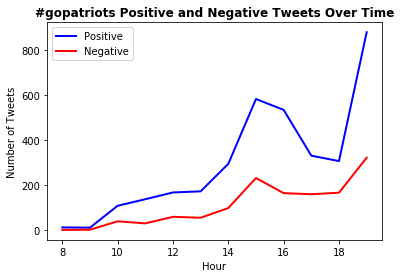

In [ ]:
plt.plot(np.arange(8, 20), patriots_positive, label='Positive', color='b', linewidth=2)
plt.plot(np.arange(8, 20), patriots_negative, label='Negative', color='r', linewidth=2)
plt.xlabel('Hour')
plt.ylabel('Number of Tweets')
plt.legend()
plt.title('#gopatriots Positive and Negative Tweets Over Time', weight='bold')
plt.show()

#Data Cleaning

In [5]:
def clean(text):
  text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
  if text=="":
    return ""
  texter = re.sub(r"<br />", " ", text)
  texter = re.sub(r"&quot;", "\"",texter)
  texter = re.sub('&#39;', "\"", texter)
  texter = re.sub('\n', " ", texter)
  texter = re.sub(' u '," you ", texter)
  texter = re.sub('`',"", texter)
  texter = re.sub(' +', ' ', texter)
  texter = re.sub(r"(!)\1+", r"!", texter)
  texter = re.sub(r"(\?)\1+", r"?", texter)
  texter = re.sub('&amp;', 'and', texter)
  texter = re.sub('\r', ' ',texter)
  clean = re.compile('<.*?>')
  texter = texter.encode('ascii', 'ignore').decode('ascii')
  texter = re.sub(clean, '', texter)
  
  return texter

In [6]:
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from collections import defaultdict

# pos_tags: treebank to wordnet
tag_map = defaultdict(lambda: wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

wnl = WordNetLemmatizer()
    
def lemmatize(data):
    lemmatized = []
    
    for doc in data:
        doc = clean(doc)
        tokens = word_tokenize(doc)
        words = [wnl.lemmatize(word, tag_map[tag[0]]) for word,tag in pos_tag(tokens) 
                 if wnl.lemmatize(word, tag_map[tag[0]]).isalpha()]
        sentence = ' '.join(words)
        lemmatized.append(sentence)
    return lemmatized

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


#Go Hawks Dataset

In [39]:
seahawks_sentiment,tweets_hawks, y_hawks, seahawks_positive, seahawks_negative = perform_sentiment_analysis('/content/drive/MyDrive/ECE219/Project4/ECE219_tweet_data/tweets_#gohawks.txt')


In [23]:
print(np.array(tweets_hawks).shape)
print(np.array(y_hawks).shape)



(3403,)
(3403,)
1


In [24]:
from wordcloud import WordCloud, STOPWORDS

In [42]:
y_pos=[]
x_pos=[]
y_neg=[]
x_neg=[]
for i in range(len(y_hawks)):
  if y_hawks[i]==0:
    y_neg.append(y_hawks[i])
    x_neg.append(tweets_hawks[i])
  else:
    y_pos.append(y_hawks[i])
    x_pos.append(tweets_hawks[i])


In [44]:
print(np.array(y_pos).shape)
print(np.array(x_pos).shape)

print(np.array(y_neg).shape)
print(np.array(x_neg).shape)

(2467,)
(2467,)
(936,)
(936,)


In [45]:
words = ' '.join(x_pos)

(-0.5, 2999.5, 2499.5, -0.5)

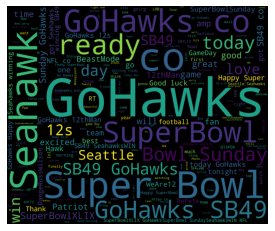

In [46]:
wordcloud = WordCloud(stopwords = 
                      STOPWORDS, background_color='black', 
                      height = 2500, width = 3000).generate(words)
plt.imshow(wordcloud)
plt.axis('off')

In [47]:
words = ' '.join(x_neg)

(-0.5, 2999.5, 2499.5, -0.5)

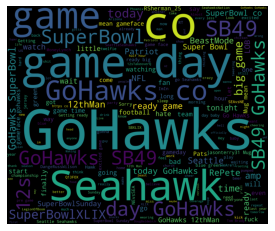

In [48]:
wordcloud = WordCloud(stopwords = 
                      STOPWORDS, background_color='black', 
                      height = 2500, width = 3000).generate(words)
plt.imshow(wordcloud)
plt.axis('off')

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# x_superbowl = np.array(superbowl_dataset_trimmed)[:, 0]
# y_superbowl = np.array(superbowl_dataset_trimmed)[:, 1]

# y_superbowl_binary = np.zeros(y_superbowl.shape)
# y_superbowl_binary[y_superbowl == 'Washington'] = 1
tweets_hawks = np.array(tweets_hawks)
y_hawks = np.array(y_hawks)
y_hawks = y_hawks.reshape(len(y_hawks),1)
#print(hawks_dataset[0], y_hawks)
print(tweets_hawks.shape, y_hawks.shape)
x_train, x_test, y_train, y_test = train_test_split(tweets_hawks, y_hawks, test_size=0.2, random_state=42)

(3403,) (3403, 1)


In [ ]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

# x_lemmatized = lemmatize(x)
# tfidf_vectorizer = TfidfVectorizer(stop_words='english', min_df=3)
# x_tfidf = tfidf_vectorizer.fit_transform(x_lemmatized)
# svd = TruncatedSVD(n_components=50, random_state=42)
# x_svd = svd.fit_transform(x_tfidf)

# data = np.append(x_svd,y,axis=1)
# print(data.shape)
import re
x_train_lemmatized = lemmatize(x_train)
x_test_lemmatized = lemmatize(x_test)

tfidf_vectorizer = TfidfVectorizer(stop_words='english', min_df=3)
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train_lemmatized)
x_test_tfidf = tfidf_vectorizer.transform(x_test_lemmatized)

svd = TruncatedSVD(n_components=50, random_state=42)
x_train_svd = svd.fit_transform(x_train_tfidf)
x_test_svd = svd.transform(x_test_tfidf)

#scale = StandardScaler()
#y_train_scaled = scale.fit_transform(y_train)
#y_test_scaled = scale.fit_transform(y_test)
#y_scaled = scale.fit_transform(y)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf.fit(x_train_svd, y_train)
clf.score(x_test_svd, y_test)

0.7973568281938326

In [ ]:
# Logistic Regression: GridSearch
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import pandas as pd


grid_logistic = GridSearchCV(estimator=LogisticRegression(random_state=42), 
                        param_grid={'C':[10**-2,10**-1,10**0,10**1,10**2],
                                   'penalty': [ 'l2', 'none']}, 
                        cv=4, n_jobs=-1, verbose=1).fit(x_train_svd, y_train)

result_logistic = pd.DataFrame(grid_logistic.cv_results_)[['mean_test_score', 'param_C', 'param_penalty']]
result_logistic = result_logistic.sort_values(by=['mean_test_score'], ascending=False).reset_index(drop=True)
result_logistic.head()

Fitting 4 folds for each of 10 candidates, totalling 40 fits


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,mean_test_score,param_C,param_penalty
0,0.873991,0.01,none
1,0.873991,0.1,none
2,0.873991,1,none
3,0.873991,10,none
4,0.873991,100,none


In [ ]:
logistic_optim = LogisticRegression(penalty=grid_logistic.best_params_['penalty'], 
                                    C=grid_logistic.best_params_['C'], random_state=42)

logistic_optim.fit(x_train_svd,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=0.01, penalty='none', random_state=42)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

y_pred_logistic = logistic_optim.predict(x_test_svd)
y_pred_prob_logistic = logistic_optim.predict_proba(x_test_svd)[:,1]

print('Logistic Regression:')
print('confusion_matrix:\n', confusion_matrix(y_test, y_pred_logistic))
print('accuracy:', accuracy_score(y_test, y_pred_logistic))
print('recall:', recall_score(y_test, y_pred_logistic))
print('precision:', precision_score(y_test, y_pred_logistic))
print('f1_score:', f1_score(y_test, y_pred_logistic))

Logistic Regression:
confusion_matrix:
 [[122  58]
 [ 25 476]]
accuracy: 0.8781204111600588
recall: 0.9500998003992016
precision: 0.8913857677902621
f1_score: 0.9198067632850242


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


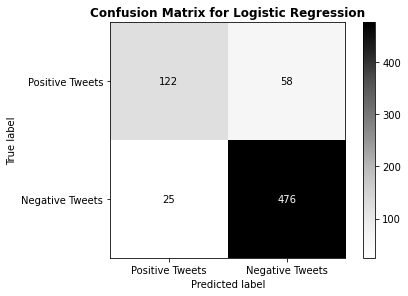

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

class_names = ['Positive Tweets', 'Negative Tweets']

plot_confusion_matrix(logistic_optim, x_test_svd, y_test, display_labels=class_names, 
                             values_format='d', cmap=plt.cm.Greys)
plt.tight_layout()
plt.title('Confusion Matrix for Logistic Regression', fontweight='bold')
plt.show()
plt.savefig('/content/drive/My Drive/figures/Q29_hawks_lr',dpi=300, bbox_inches='tight')

In [ ]:
# RandomForest: GridSearch
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

pipe_rfc = Pipeline([
    ('standardize', StandardScaler()),
    ('model', RandomForestClassifier(random_state=42))
])

param_grid = {
    'model__max_depth': [10, 30, 50, 70, 100, 200, None]
}


grid_rfc = GridSearchCV(pipe_rfc, param_grid=param_grid, cv=KFold(5, shuffle=True, random_state=42), n_jobs=-1, verbose=1)
grid_rfc.fit(x_train_svd, y_train)

result_rfc = pd.DataFrame(grid_rfc.cv_results_)[['mean_test_score', 'param_model__max_depth']]
result_rfc = result_rfc.sort_values(by=['mean_test_score'], ascending=False).reset_index(drop=True)
result_rfc.head()

Fitting 5 folds for each of 7 candidates, totalling 35 fits


/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


,mean_test_score,param_model__max_depth
0,0.862229,30
1,0.862229,50
2,0.862229,70
3,0.862229,100
4,0.862229,200


In [ ]:
grid_rfc.best_params_

{'model__max_depth': 30}

In [ ]:
rfc_optim = RandomForestClassifier(max_depth=grid_rfc.best_params_['model__max_depth'], 
                                    random_state=42)

rfc_optim.fit(x_train_svd, y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestClassifier(max_depth=30, random_state=42)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

y_pred_rfc = rfc_optim.predict(x_test_svd)
y_pred_prob_rfc = rfc_optim.predict_proba(x_test_svd)[:,1]

print('Random Forest Regression:')
print('confusion_matrix:\n', confusion_matrix(y_test, y_pred_rfc))
print('accuracy:', accuracy_score(y_test, y_pred_rfc))
print('recall:', recall_score(y_test, y_pred_rfc))
print('precision:', precision_score(y_test, y_pred_rfc))
print('f1_score:', f1_score(y_test, y_pred_rfc))

Random Forest Regression:
confusion_matrix:
 [[107  73]
 [ 17 484]]
accuracy: 0.8678414096916299
recall: 0.9660678642714571
precision: 0.8689407540394973
f1_score: 0.9149338374291115


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


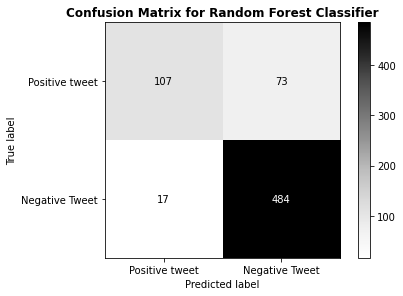

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

class_names = ['Positive tweet', 'Negative Tweet']

plot_confusion_matrix(rfc_optim, x_test_svd, y_test, display_labels=class_names, 
                             values_format='d', cmap=plt.cm.Greys)
plt.tight_layout()
plt.title('Confusion Matrix for Random Forest Classifier', fontweight='bold')
plt.show()
plt.savefig('/content/drive/My Drive/figures/Q29_hawks_rf', dpi=300, bbox_inches='tight')

#Gopatriots Datset

In [49]:
patriots_sentiment, tweets_patriots, y_patriots, patriots_positive, patriots_negative = perform_sentiment_analysis('/content/drive/MyDrive/ECE219/Project4/ECE219_tweet_data/tweets_#gopatriots.txt')

In [50]:
from wordcloud import WordCloud, STOPWORDS

In [51]:
y_pos=[]
x_pos=[]
y_neg=[]
x_neg=[]
for i in range(len(y_patriots)):
  if y_patriots[i]==0:
    y_neg.append(y_patriots[i])
    x_neg.append(tweets_patriots[i])
  else:
    y_pos.append(y_patriots[i])
    x_pos.append(tweets_patriots[i])


In [52]:
print(np.array(y_pos).shape)
print(np.array(x_pos).shape)

print(np.array(y_neg).shape)
print(np.array(x_neg).shape)

(315,)
(315,)
(97,)
(97,)


In [53]:
words = ' '.join(x_pos)

(-0.5, 2999.5, 2499.5, -0.5)

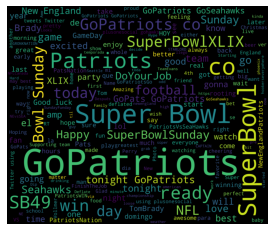

In [54]:
wordcloud = WordCloud(stopwords = 
                      STOPWORDS, background_color='black', 
                      height = 2500, width = 3000).generate(words)
plt.imshow(wordcloud)
plt.axis('off')

In [55]:
words = ' '.join(x_neg)

(-0.5, 2999.5, 2499.5, -0.5)

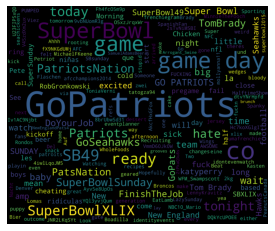

In [56]:
wordcloud = WordCloud(stopwords = 
                      STOPWORDS, background_color='black', 
                      height = 2500, width = 3000).generate(words)
plt.imshow(wordcloud)
plt.axis('off')

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# x_superbowl = np.array(superbowl_dataset_trimmed)[:, 0]
# y_superbowl = np.array(superbowl_dataset_trimmed)[:, 1]

# y_superbowl_binary = np.zeros(y_superbowl.shape)
# y_superbowl_binary[y_superbowl == 'Washington'] = 1
tweets_patriots = np.array(tweets_patriots)
y_patriots = np.array(y_patriots)
y_patriots = y_patriots.reshape(len(y_patriots),1)
#print(patriots_dataset[0], y_patriots)
print(tweets_patriots.shape, y_patriots.shape)
x_train, x_test, y_train, y_test = train_test_split(tweets_patriots, y_patriots, test_size=0.2, random_state=42)

(412,) (412, 1)


In [ ]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

# x_lemmatized = lemmatize(x)
# tfidf_vectorizer = TfidfVectorizer(stop_words='english', min_df=3)
# x_tfidf = tfidf_vectorizer.fit_transform(x_lemmatized)
# svd = TruncatedSVD(n_components=50, random_state=42)
# x_svd = svd.fit_transform(x_tfidf)

# data = np.append(x_svd,y,axis=1)
# print(data.shape)
import re
x_train_lemmatized = lemmatize(x_train)
x_test_lemmatized = lemmatize(x_test)

tfidf_vectorizer = TfidfVectorizer(stop_words='english', min_df=3)
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train_lemmatized)
x_test_tfidf = tfidf_vectorizer.transform(x_test_lemmatized)

svd = TruncatedSVD(n_components=50, random_state=42)
x_train_svd = svd.fit_transform(x_train_tfidf)
x_test_svd = svd.transform(x_test_tfidf)

#scale = StandardScaler()
#y_train_scaled = scale.fit_transform(y_train)
#y_test_scaled = scale.fit_transform(y_test)
#y_scaled = scale.fit_transform(y)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf.fit(x_train_svd, y_train)
clf.score(x_test_svd, y_test)

0.7710843373493976

In [ ]:
# Logistic Regression: GridSearch
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import pandas as pd


grid_logistic = GridSearchCV(estimator=LogisticRegression(random_state=42), 
                        param_grid={'C':[10**-2,10**-1,10**0,10**1,10**2],
                                   'penalty': [ 'l2', 'none']}, 
                        cv=4, n_jobs=-1, verbose=1).fit(x_train_svd, y_train)

result_logistic = pd.DataFrame(grid_logistic.cv_results_)[['mean_test_score', 'param_C', 'param_penalty']]
result_logistic = result_logistic.sort_values(by=['mean_test_score'], ascending=False).reset_index(drop=True)
result_logistic.head()

Fitting 4 folds for each of 10 candidates, totalling 40 fits


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,mean_test_score,param_C,param_penalty
0,0.869453,10,l2
1,0.857185,1,l2
2,0.835990,100,l2
3,0.805760,0.01,none
4,0.805760,0.1,none


In [ ]:
logistic_optim = LogisticRegression(penalty=grid_logistic.best_params_['penalty'], 
                                    C=grid_logistic.best_params_['C'], random_state=42)

logistic_optim.fit(x_train_svd,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=10, random_state=42)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

y_pred_logistic = logistic_optim.predict(x_test_svd)
y_pred_prob_logistic = logistic_optim.predict_proba(x_test_svd)[:,1]

print('Logistic Regression:')
print('confusion_matrix:\n', confusion_matrix(y_test, y_pred_logistic))
print('accuracy:', accuracy_score(y_test, y_pred_logistic))
print('recall:', recall_score(y_test, y_pred_logistic))
print('precision:', precision_score(y_test, y_pred_logistic))
print('f1_score:', f1_score(y_test, y_pred_logistic))

Logistic Regression:
confusion_matrix:
 [[ 9  9]
 [ 2 63]]
accuracy: 0.8674698795180723
recall: 0.9692307692307692
precision: 0.875
f1_score: 0.9197080291970802


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


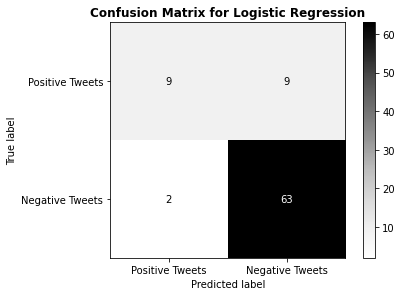

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

class_names = ['Positive Tweets', 'Negative Tweets']

plot_confusion_matrix(logistic_optim, x_test_svd, y_test, display_labels=class_names, 
                             values_format='d', cmap=plt.cm.Greys)
plt.tight_layout()
plt.title('Confusion Matrix for Logistic Regression', fontweight='bold')
plt.show()
plt.savefig('/content/drive/My Drive/figures/Q29_patriots_lr',dpi=300, bbox_inches='tight')

In [ ]:
# RandomForest: GridSearch
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

pipe_rfc = Pipeline([
    ('standardize', StandardScaler()),
    ('model', RandomForestClassifier(random_state=42))
])

param_grid = {
    'model__max_depth': [10, 30, 50, 70, 100, 200, None]
}


grid_rfc = GridSearchCV(pipe_rfc, param_grid=param_grid, cv=KFold(5, shuffle=True, random_state=42), n_jobs=-1, verbose=1)
grid_rfc.fit(x_train_svd, y_train)

result_rfc = pd.DataFrame(grid_rfc.cv_results_)[['mean_test_score', 'param_model__max_depth']]
result_rfc = result_rfc.sort_values(by=['mean_test_score'], ascending=False).reset_index(drop=True)
result_rfc.head()

Fitting 5 folds for each of 7 candidates, totalling 35 fits


/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


,mean_test_score,param_model__max_depth
0,0.857063,10
1,0.857016,30
2,0.857016,50
3,0.857016,70
4,0.857016,100


In [ ]:
grid_rfc.best_params_

{'model__max_depth': 10}

In [ ]:
rfc_optim = RandomForestClassifier(max_depth=grid_rfc.best_params_['model__max_depth'], 
                                    random_state=42)

rfc_optim.fit(x_train_svd, y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestClassifier(max_depth=10, random_state=42)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

y_pred_rfc = rfc_optim.predict(x_test_svd)
y_pred_prob_rfc = rfc_optim.predict_proba(x_test_svd)[:,1]

print('Random Forest Regression:')
print('confusion_matrix:\n', confusion_matrix(y_test, y_pred_rfc))
print('accuracy:', accuracy_score(y_test, y_pred_rfc))
print('recall:', recall_score(y_test, y_pred_rfc))
print('precision:', precision_score(y_test, y_pred_rfc))
print('f1_score:', f1_score(y_test, y_pred_rfc))

Random Forest Regression:
confusion_matrix:
 [[ 8 10]
 [ 0 65]]
accuracy: 0.8795180722891566
recall: 1.0
precision: 0.8666666666666667
f1_score: 0.9285714285714286


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


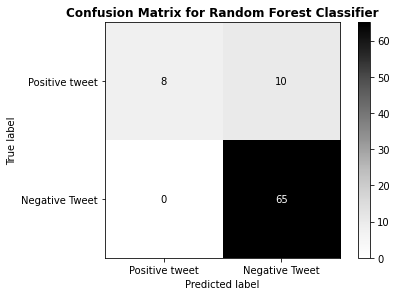

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

class_names = ['Positive tweet', 'Negative Tweet']

plot_confusion_matrix(rfc_optim, x_test_svd, y_test, display_labels=class_names, 
                             values_format='d', cmap=plt.cm.Greys)
plt.tight_layout()
plt.title('Confusion Matrix for Random Forest Classifier', fontweight='bold')
plt.show()
plt.savefig('/content/drive/My Drive/figures/Q29_patriots_rf', dpi=300, bbox_inches='tight')

#NFL Dataset

In [ ]:
sea_sentiment,tweets_nfl, y_nfl, sea_positive, sea_negative = perform_sentiment_analysis('/content/drive/MyDrive/ECE219/Project4/ECE219_tweet_data/tweets_#nfl.txt')


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# x_superbowl = np.array(superbowl_dataset_trimmed)[:, 0]
# y_superbowl = np.array(superbowl_dataset_trimmed)[:, 1]

# y_superbowl_binary = np.zeros(y_superbowl.shape)
# y_superbowl_binary[y_superbowl == 'Washington'] = 1
tweets_nfl = np.array(tweets_nfl)
y_nfl = np.array(y_nfl)
y_nfl = y_nfl.reshape(len(y_nfl),1)
#print(nfl_dataset[0], y_nfl)
print(tweets_nfl.shape, y_nfl.shape)
x_train, x_test, y_train, y_test = train_test_split(tweets_nfl, y_nfl, test_size=0.2, random_state=42)

(4994,) (4994, 1)


In [ ]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

# x_lemmatized = lemmatize(x)
# tfidf_vectorizer = TfidfVectorizer(stop_words='english', min_df=3)
# x_tfidf = tfidf_vectorizer.fit_transform(x_lemmatized)
# svd = TruncatedSVD(n_components=50, random_state=42)
# x_svd = svd.fit_transform(x_tfidf)

# data = np.append(x_svd,y,axis=1)
# print(data.shape)
import re
x_train_lemmatized = lemmatize(x_train)
x_test_lemmatized = lemmatize(x_test)

tfidf_vectorizer = TfidfVectorizer(stop_words='english', min_df=3)
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train_lemmatized)
x_test_tfidf = tfidf_vectorizer.transform(x_test_lemmatized)

svd = TruncatedSVD(n_components=50, random_state=42)
x_train_svd = svd.fit_transform(x_train_tfidf)
x_test_svd = svd.transform(x_test_tfidf)

#scale = StandardScaler()
#y_train_scaled = scale.fit_transform(y_train)
#y_test_scaled = scale.fit_transform(y_test)
#y_scaled = scale.fit_transform(y)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf.fit(x_train_svd, y_train)
clf.score(x_test_svd, y_test)

0.8188188188188188

In [ ]:
# Logistic Regression: GridSearch
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import pandas as pd


grid_logistic = GridSearchCV(estimator=LogisticRegression(random_state=42), 
                        param_grid={'C':[10**-2,10**-1,10**0,10**1,10**2],
                                   'penalty': [ 'l2', 'none']}, 
                        cv=4, n_jobs=-1, verbose=1).fit(x_train_svd, y_train)

result_logistic = pd.DataFrame(grid_logistic.cv_results_)[['mean_test_score', 'param_C', 'param_penalty']]
result_logistic = result_logistic.sort_values(by=['mean_test_score'], ascending=False).reset_index(drop=True)
result_logistic.head()

Fitting 4 folds for each of 10 candidates, totalling 40 fits


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,mean_test_score,param_C,param_penalty
0,0.865581,10,l2
1,0.864830,100,l2
2,0.864329,0.01,none
3,0.864329,0.1,none
4,0.864329,1,none


In [ ]:
logistic_optim = LogisticRegression(penalty=grid_logistic.best_params_['penalty'], 
                                    C=grid_logistic.best_params_['C'], random_state=42)

logistic_optim.fit(x_train_svd,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=10, random_state=42)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

y_pred_logistic = logistic_optim.predict(x_test_svd)
y_pred_prob_logistic = logistic_optim.predict_proba(x_test_svd)[:,1]

print('Logistic Regression:')
print('confusion_matrix:\n', confusion_matrix(y_test, y_pred_logistic))
print('accuracy:', accuracy_score(y_test, y_pred_logistic))
print('recall:', recall_score(y_test, y_pred_logistic))
print('precision:', precision_score(y_test, y_pred_logistic))
print('f1_score:', f1_score(y_test, y_pred_logistic))

Logistic Regression:
confusion_matrix:
 [[121 117]
 [ 23 738]]
accuracy: 0.8598598598598599
recall: 0.9697766097240473
precision: 0.8631578947368421
f1_score: 0.9133663366336634


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


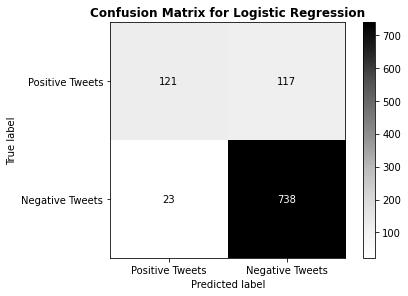

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

class_names = ['Positive Tweets', 'Negative Tweets']

plot_confusion_matrix(logistic_optim, x_test_svd, y_test, display_labels=class_names, 
                             values_format='d', cmap=plt.cm.Greys)
plt.tight_layout()
plt.title('Confusion Matrix for Logistic Regression', fontweight='bold')
plt.show()
plt.savefig('/content/drive/My Drive/figures/Q29_nfl_lr', dpi=300, bbox_inches='tight')

In [ ]:
# RandomForest: GridSearch
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

pipe_rfc = Pipeline([
    ('standardize', StandardScaler()),
    ('model', RandomForestClassifier(random_state=42))
])

param_grid = {
    'model__max_depth': [10, 30, 50, 70, 100, 200, None]
}


grid_rfc = GridSearchCV(pipe_rfc, param_grid=param_grid, cv=KFold(5, shuffle=True, random_state=42), n_jobs=-1, verbose=1)
grid_rfc.fit(x_train_svd, y_train)

result_rfc = pd.DataFrame(grid_rfc.cv_results_)[['mean_test_score', 'param_model__max_depth']]
result_rfc = result_rfc.sort_values(by=['mean_test_score'], ascending=False).reset_index(drop=True)
result_rfc.head()

Fitting 5 folds for each of 7 candidates, totalling 35 fits


/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


,mean_test_score,param_model__max_depth
0,0.882103,50
1,0.882103,70
2,0.882103,100
3,0.882103,200
4,0.882103,None


In [ ]:
grid_rfc.best_params_

{'model__max_depth': 50}

In [ ]:
rfc_optim = RandomForestClassifier(max_depth=grid_rfc.best_params_['model__max_depth'], 
                                    random_state=42)

rfc_optim.fit(x_train_svd, y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestClassifier(max_depth=50, random_state=42)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

y_pred_rfc = rfc_optim.predict(x_test_svd)
y_pred_prob_rfc = rfc_optim.predict_proba(x_test_svd)[:,1]

print('Random Forest Regression:')
print('confusion_matrix:\n', confusion_matrix(y_test, y_pred_rfc))
print('accuracy:', accuracy_score(y_test, y_pred_rfc))
print('recall:', recall_score(y_test, y_pred_rfc))
print('precision:', precision_score(y_test, y_pred_rfc))
print('f1_score:', f1_score(y_test, y_pred_rfc))

Random Forest Regression:
confusion_matrix:
 [[122 116]
 [ 13 748]]
accuracy: 0.8708708708708709
recall: 0.9829172141918529
precision: 0.8657407407407407
f1_score: 0.9206153846153845


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


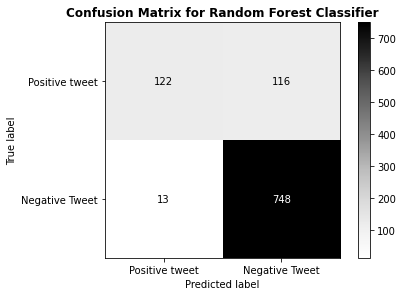

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

class_names = ['Positive tweet', 'Negative Tweet']

plot_confusion_matrix(rfc_optim, x_test_svd, y_test, display_labels=class_names, 
                             values_format='d', cmap=plt.cm.Greys)
plt.tight_layout()
plt.title('Confusion Matrix for Random Forest Classifier', fontweight='bold')
plt.show()
plt.savefig('/content/drive/My Drive/figures/Q29_nfl_rf', dpi=300, bbox_inches='tight')